<a href="https://colab.research.google.com/github/cosshoon/Anomaly-Detection-/blob/main/FFT(%EC%A0%84%EC%B2%98%EB%A6%AC)%2C_AE%ED%99%9C%EC%9A%A9_Anomaly_Detection%2C_%EC%84%B1%EB%8A%A5%ED%96%A5%EC%83%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/g')

Mounted at /g


In [ ]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, ReLU, Dropout
from tensorflow.keras.callbacks import TensorBoard
# Loading tensorboard extension
%load_ext tensorboard

In [ ]:
merged_database = pd.read_csv('/g/MyDrive/Machine Learning/SK fellowship/Dataset/IMS dataset/Averaged_BearingTest_Dataset_2nd.csv', index_col = 0)
merged_database.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [ ]:
merged_database.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


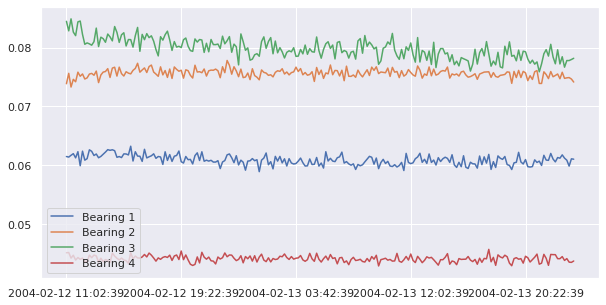

In [ ]:
train_dataset = merged_database['2004-02-12 11:02:39':'2004-02-13 23:52:39']
test_dataset = merged_database['2004-02-13 23:52:39' :]

train_dataset.plot(figsize = (10, 5))

In [ ]:
train_dataset.shape

(222, 4)

In [ ]:
train_fft = np.fft.fft(train_dataset)
test_fft = np.fft.fft(test_dataset)

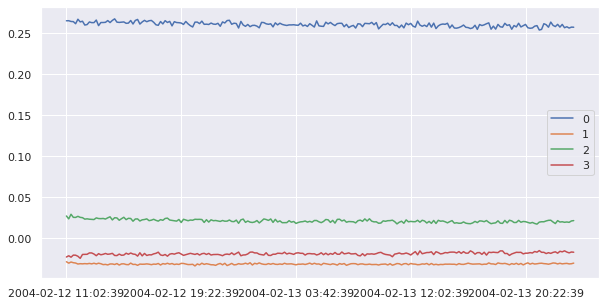

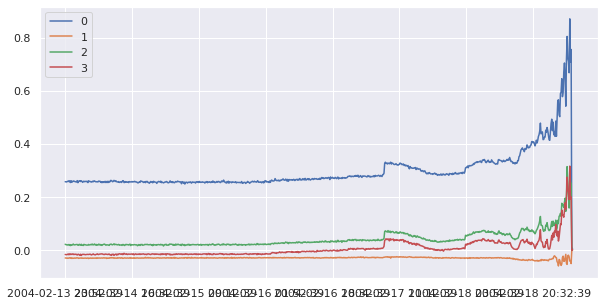

In [ ]:
train_fft_dataset = pd.DataFrame([train_fft[:,0].real, train_fft[:,1].imag, train_fft[:,2].real, train_fft[:,3].real])
train_fft_dataset = train_fft_dataset.transpose()
train_fft_dataset.index = train_dataset.index

train_fft_dataset.plot(figsize = (10, 5))



test_fft_dataset = pd.DataFrame([test_fft[:,0].real,test_fft[:,1].imag,test_fft[:,2].real, test_fft[:,3].real])
test_fft_dataset = test_fft_dataset.transpose()
test_fft_dataset.index = test_dataset.index

test_fft_dataset.plot(figsize = (10, 5))

In [ ]:
def scaling_data(train_fft, test_fft):
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(train_fft), 
                          columns=train_fft.columns,
                          index=train_fft.index)
    
    # Randomly shuffle training database
    X_train.sample(frac=1)
    
    X_test = pd.DataFrame(scaler.transform(test_fft), 
                          columns=test_fft.columns,
                          index=test_fft.index)
    return (X_train, X_test)

In [ ]:
X_train, X_test = scaling_data(train_fft_dataset, test_fft_dataset)

In [ ]:
BATCH_SIZE = 10
EPOCHS = 100
DROPOUT_RATE = 0.2

Autoencoder 기반 알고리즘 적용

In [ ]:
def autoencoder_model(dropout_rate):
    # Input Layer
    input_x = Input(shape=(X_train.shape[1],))

    # Hidden Layer # 1
    X = Dense(10, use_bias=True, kernel_initializer='glorot_uniform',name='Hidden_1')(input_x)
    X = Dropout(rate=dropout_rate, name='Dropout_1')(X)
    X = ReLU(negative_slope=0, name='RELU_1')(X)

    # Hidden Layer # 2
    X = Dense(6, use_bias=True, kernel_initializer='glorot_uniform',name='Hidden_2')(X)
    X = ReLU(negative_slope=0, name='RELU_2')(X)

    # Hidden Layer # 3
    X = Dense(2, use_bias=True, kernel_initializer='glorot_uniform', name='Hidden_3')(X)
    X = ReLU(negative_slope=0, name='RELU_3')(X)
    
    # Hidden Layer # 4
    X = Dense(6, use_bias=True, kernel_initializer='glorot_uniform',name='Hidden_4')(X)
    X = ReLU(negative_slope=0, name='RELU_4')(X)

    # Hidden Layer # 5
    X = Dense(10, use_bias=True, kernel_initializer='glorot_uniform', name='Hidden_5')(X)
    X = ReLU(negative_slope=0, name='RELU_5')(X)

    # Output Layer
    output_x = Dense(X_train.shape[1], use_bias=True, kernel_initializer='glorot_uniform', name='Output')(X)

    # Defining the model
    model = Model(inputs=[input_x], outputs=[output_x])
    return model

In [ ]:
model = autoencoder_model(DROPOUT_RATE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
Hidden_1 (Dense)             (None, 10)                50        
_________________________________________________________________
Dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
RELU_1 (ReLU)                (None, 10)                0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 6)                 66        
_________________________________________________________________
RELU_2 (ReLU)                (None, 6)                 0         
_________________________________________________________________
Hidden_3 (Dense)             (None, 2)                 14    

In [ ]:
# Configuring the model for training
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Initializing TensorBoard callbacks
log_dir = '.\\logs\\fit\\' +  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Training the model
history = model.fit(x=np.array(X_train), y=np.array(X_train), batch_size=BATCH_SIZE,
                           epochs=EPOCHS, validation_split=0.05, verbose = 1,
                           callbacks=[tensorboard_callback])

Epoch 1/100
21/21 [==============================] - 1s 33ms/step - loss: 0.1905 - val_loss: 0.1997
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1341 - val_loss: 0.1578
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0936 - val_loss: 0.1302
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0638 - val_loss: 0.1024
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 0.0785
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0405 - val_loss: 0.0616
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0327 - val_loss: 0.0493
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0418
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.0389
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0373
Epoch 11

In [ ]:
def plot_learning_rates(history):
    plt.plot(history.history['loss'],'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss, [mse]')
    plt.ylim([0, 0.1])
    plt.show()

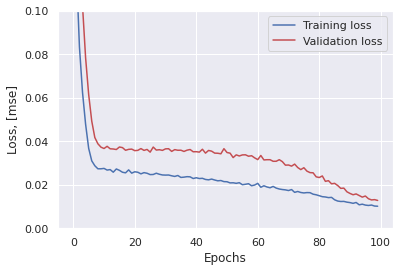

In [ ]:
plot_learning_rates(history)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

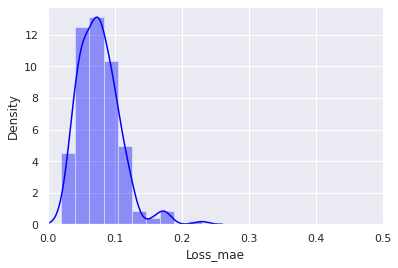

In [ ]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, columns=X_train.columns, index=X_train.index)

recon_error = pd.DataFrame(index=X_train.index)
recon_error['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

plt.figure()
sns.distplot(recon_error['Loss_mae'],bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# Picking the right threshold from distribution data shown above
THRESHOLD = 0.2

In [ ]:
X_pred_test = model.predict(np.array(X_test))
X_pred_test = pd.DataFrame(X_pred_test, columns=X_test.columns, index=X_test.index)

In [ ]:
recon_error_test = pd.DataFrame(index=X_test.index)
recon_error_test['Loss_mae'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)
recon_error_test['Threshold'] = THRESHOLD
recon_error_test['Anomaly'] = recon_error_test['Loss_mae'] > recon_error_test['Threshold']
recon_error_test.head()

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.112745,0.2,False
2004-02-14 00:02:39,0.085767,0.2,False
2004-02-14 00:12:39,0.041099,0.2,False
2004-02-14 00:22:39,0.088989,0.2,False
2004-02-14 00:32:39,0.108674,0.2,False


In [ ]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

recon_error_train = pd.DataFrame(index=X_train.index)
recon_error_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
recon_error_train['Threshold'] = THRESHOLD
recon_error_train['Anomaly'] = recon_error_train['Loss_mae'] > recon_error_train['Threshold']
recon_error = pd.concat([recon_error_train, recon_error_test])

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text major ticklabel objects>)

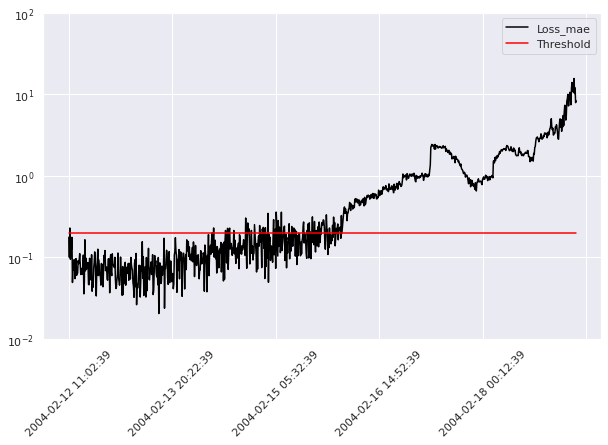

In [ ]:
recon_error.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['black','red'])
plt.xticks(rotation=45)